In [169]:
import os
import sys
sys.path.append('../')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

from authenticate_service_account import main
from utils import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import load_model
import SALib as sa
from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split


In [90]:
# client = main()

# query = """
# SELECT *
# FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
# """

# query_job = client.query(query)

# results = query_job.result()


In [91]:
# data = results.to_dataframe()


In [92]:
# data.to_csv('4Mrows.csv', index=False)


In [93]:
# data = pd.read_csv('../raw_data/all_data_30_horizon_with_day_of_week.csv')


In [94]:
# data.columns


## Running preprocessor

In [95]:
# processed_data = preprocess(data, raw_od_columns=['OriginCty', 'DestinationCty'], raw_od_ctry=['OriginCtry', 'DestinationCtry'] , as_ratio=True)
# processed_data


In [96]:
# processed_data.to_csv('processed_data.csv', index=False)


In [97]:
data = pd.read_csv('../raw_data/processed_data.csv')


In [98]:
data.columns


Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'dayofweek', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
   

### Checking the distribution of the target (Score_Z_score_0_50)


In [99]:
data.value_counts()


OriginApt  OriginCty  OriginCtry  DestinationApt  DestinationCty  DestinationCtry  TravelHorizonDays  TravelDistanceKm  SelfTransfer  Stops  DurationMin  Seg_0_OriginIATA  Seg_0_OriginName             Seg_0_DestinationIATA  Seg_0_DestinationName                   dayofweek  Seg_0_OperatingCarrierIATA  Seg_0_TravelDistanceKm  Seg_1_OriginIATA  Seg_1_OriginName                        Seg_1_DestinationIATA  Seg_1_DestinationName  Seg_1_OperatingCarrierIATA  Seg_1_TravelDistanceKm  Seg_2_OriginIATA  Seg_2_OriginName       Seg_2_DestinationIATA  Seg_2_DestinationName  Seg_2_OperatingCarrierIATA  Seg_2_TravelDistanceKm  Seg_3_OriginIATA  Seg_3_OriginName       Seg_3_DestinationIATA  Seg_3_DestinationName  Seg_3_OperatingCarrierIATA  Seg_3_TravelDistanceKm  Seg_0_DurationMin  Seg_1_DurationMin  Seg_2_DurationMin  Seg_3_DurationMin  passengers  SearchLowestRatio  ItinLowestRatio  Price     PricePerPax  ItineraryRedirects  ODRedirects  redirect_ratio  OD      OD_ctry  total_travel_time  total_l

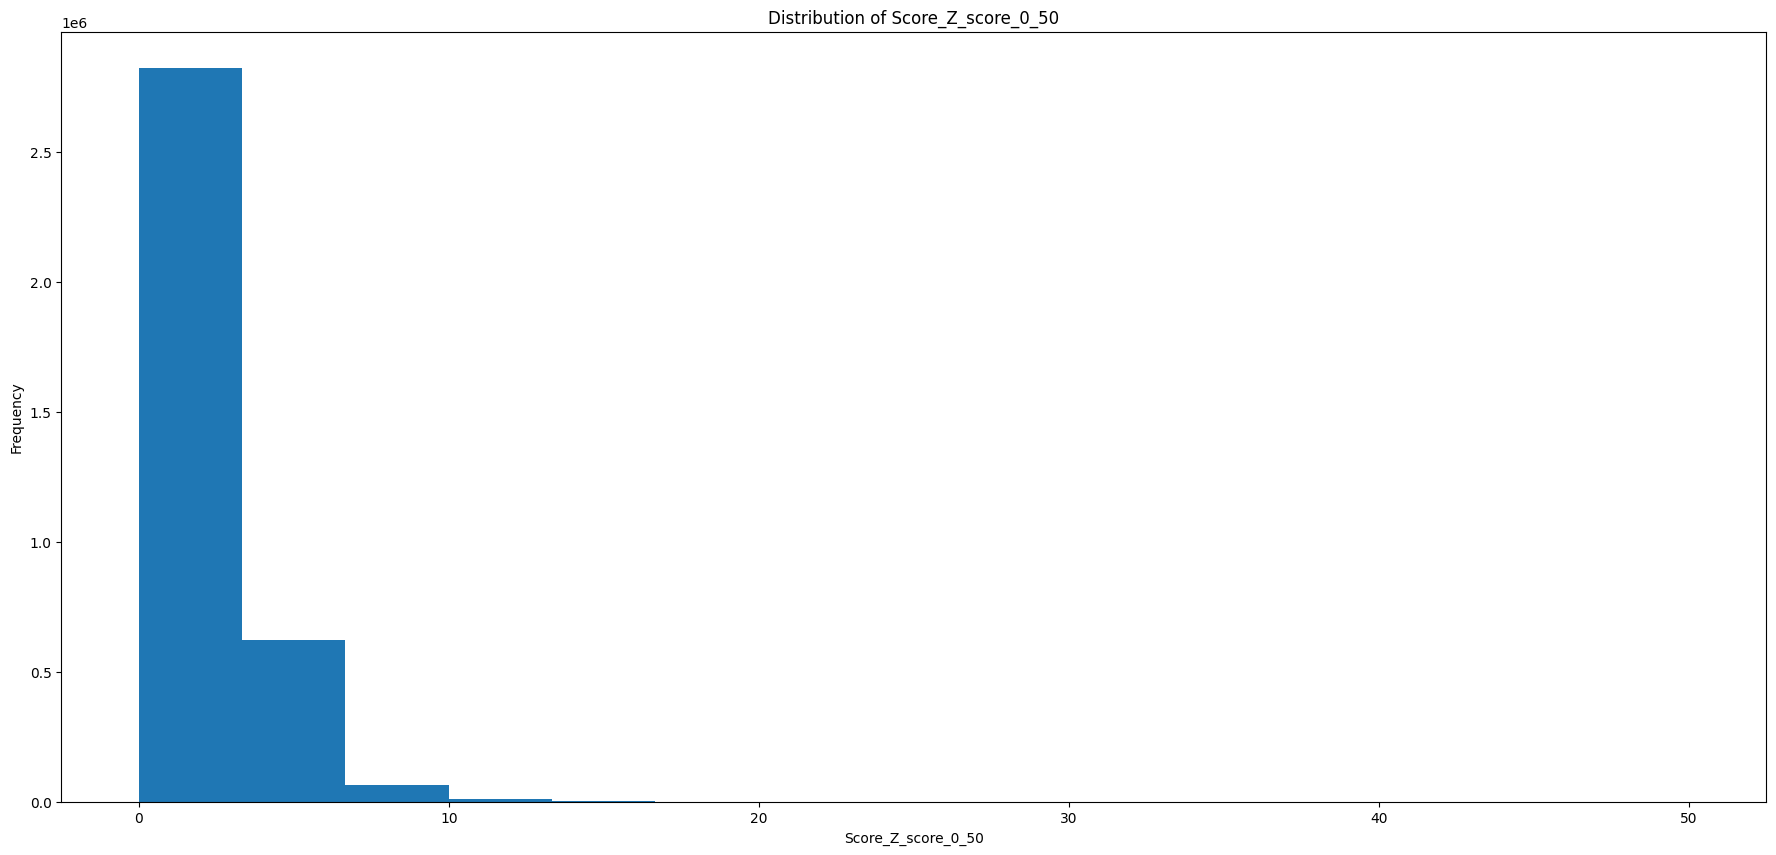

In [100]:
plt.figure(figsize=(22, 10))
plt.hist(data["Score_Z_score_0_50"], bins=15)
plt.xlabel("Score_Z_score_0_50")
plt.ylabel("Frequency")
plt.title("Distribution of Score_Z_score_0_50")
plt.show()


In [101]:
view = data.groupby(["OD", "TravelHorizonDays"])["ODRedirects"].mean()
view = view.groupby("OD").sum()
view = view.sort_values(ascending=False)
view = view.to_frame(name="ODRedirects_per_OD")
view["cumulative_sum_ODRedirects"] = view.cumsum()
view["cumulative_perc_ODRedirects"] = 100 * view.cumulative_sum_ODRedirects / view.ODRedirects_per_OD.sum()
view.reset_index(inplace=True)
view.ODRedirects_per_OD.sum()
view.head(20)


,OD,ODRedirects_per_OD,cumulative_sum_ODRedirects,cumulative_perc_ODRedirects
0,DELBOM,25343.0,25343.0,0.313046
1,BOMDEL,23571.0,48914.0,0.604203
2,SELTYO,22249.0,71163.0,0.879030
3,TYOSEL,22154.0,93317.0,1.152684
4,SELOSA,19895.0,113212.0,1.398434
5,OSASEL,19492.0,132704.0,1.639206
6,BKKSEL,18745.0,151449.0,1.870750
7,SELBKK,18430.0,169879.0,2.098404
8,CJUSEL,18067.0,187946.0,2.321574
9,SELCJU,17979.0,205925.0,2.543657


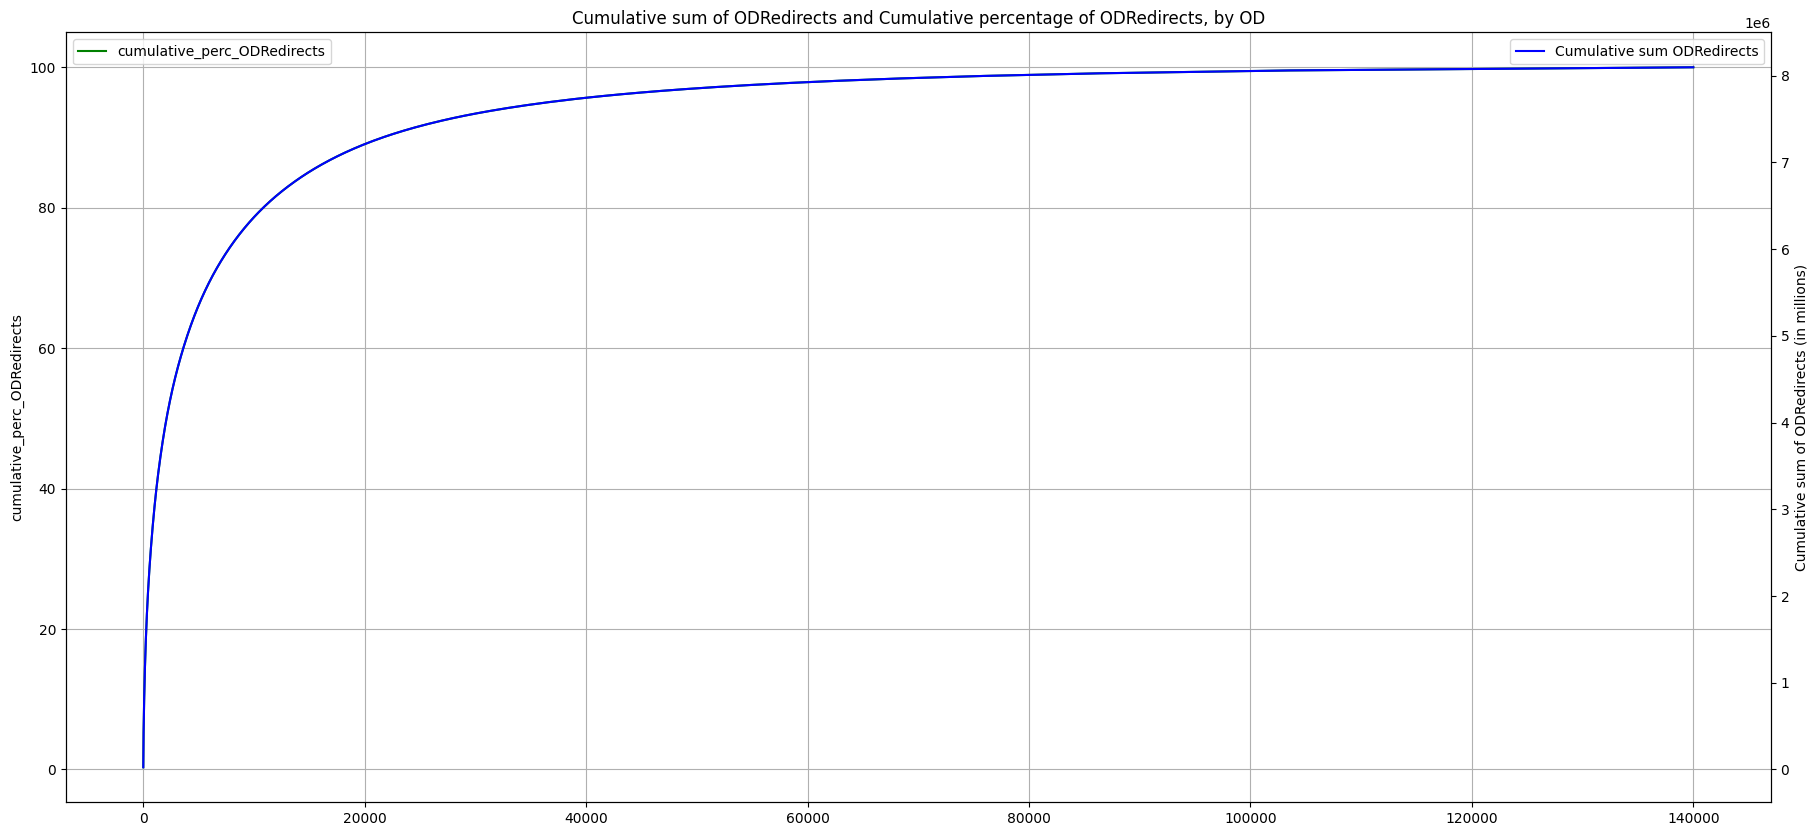

In [102]:
plt.figure(figsize=(22,10))


# First plot with twinx()
ax1 = view["cumulative_perc_ODRedirects"].plot(kind="line", color="green", label="cumulative_perc_ODRedirects", grid=True)
plt.ylabel("cumulative_perc_ODRedirects")

#Second Plot
ax2 = ax1.twinx()
view["cumulative_sum_ODRedirects"].plot(kind="line", color="blue", ax=ax2, label="Cumulative sum ODRedirects")
plt.ylabel("Cumulative sum of ODRedirects (in millions)")
plt.title("Cumulative sum of ODRedirects and Cumulative percentage of ODRedirects, by OD")


# Optional: Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


In [103]:
view.sum()


OD                             DELBOMBOMDELSELTYOTYOSELSELOSAOSASELBKKSELSELB...
ODRedirects_per_OD                                                     8095628.0
cumulative_sum_ODRedirects                                       1068822042534.0
cumulative_perc_ODRedirects                                      13202459.926938
dtype: object

In [104]:
view.describe()


,ODRedirects_per_OD,cumulative_sum_ODRedirects,cumulative_perc_ODRedirects
count,140001.000000,1.400010e+05,140001.000000
mean,57.825501,7.634389e+06,94.302612
std,357.584729,8.875846e+05,10.963753
min,1.000000,2.534300e+04,0.313046
25%,1.000000,7.665661e+06,94.688899
50%,4.000000,7.973419e+06,98.490432
75%,18.000000,8.060628e+06,99.567668
max,25343.000000,8.095628e+06,100.000000


## Filter down to the top 10,000 ODs in the view df

### Define the threshold (those ODs responsible for the first 80% of cumulative ODRedirects)

In [105]:
threshold = 80 # Percentage of ODRedirects below which to keep the ODs
view = view[view["cumulative_perc_ODRedirects"] <= threshold]
view.head(20)


,OD,ODRedirects_per_OD,cumulative_sum_ODRedirects,cumulative_perc_ODRedirects
0,DELBOM,25343.0,25343.0,0.313046
1,BOMDEL,23571.0,48914.0,0.604203
2,SELTYO,22249.0,71163.0,0.879030
3,TYOSEL,22154.0,93317.0,1.152684
4,SELOSA,19895.0,113212.0,1.398434
5,OSASEL,19492.0,132704.0,1.639206
6,BKKSEL,18745.0,151449.0,1.870750
7,SELBKK,18430.0,169879.0,2.098404
8,CJUSEL,18067.0,187946.0,2.321574
9,SELCJU,17979.0,205925.0,2.543657


In [106]:
view.describe()


,ODRedirects_per_OD,cumulative_sum_ODRedirects,cumulative_perc_ODRedirects
count,10832.000000,1.083200e+04,10832.000000
mean,597.897895,5.063608e+06,62.547443
std,1153.691348,1.305364e+06,16.124307
min,124.000000,2.534300e+04,0.313046
25%,178.000000,4.425508e+06,54.665413
50%,279.000000,5.473942e+06,67.616033
75%,550.000000,6.074300e+06,75.031863
max,25343.000000,6.476430e+06,79.999106


In [107]:
data.describe()


,TravelHorizonDays,TravelDistanceKm,Stops,DurationMin,dayofweek,Seg_0_TravelDistanceKm,Seg_1_TravelDistanceKm,Seg_2_TravelDistanceKm,Seg_3_TravelDistanceKm,Seg_0_DurationMin,...,total_travel_time,total_layover_time,total_layover_time_ratio,total_distance_traveled,extra_travel_distance_ratio,Z_Score,MinMax_Scaled,Score_min_max,Score_Z_score,Score_Z_score_0_50
count,3.694721e+06,3.638485e+06,3.694721e+06,3.694721e+06,3.694721e+06,3.694721e+06,3.694721e+06,3.694721e+06,3.694721e+06,3.694721e+06,...,3.694721e+06,3.694721e+06,3.694721e+06,3.694721e+06,3.638485e+06,3.522665e+06,3.638485e+06,3.638485e+06,3.522665e+06,3.522665e+06
mean,1.326303e+01,2.939254e+03,3.969120e-01,3.943867e+02,3.983480e+00,2.054246e+03,9.873837e+02,1.449524e+02,2.189598e+01,1.929598e+02,...,2.940511e+02,1.003356e+02,1.094760e-01,3.208478e+03,1.078825e+00,6.285286e-18,9.197244e-02,2.515762e-01,1.638755e-01,2.836612e+00
std,8.869049e+00,3.110205e+03,6.291633e-01,4.462848e+02,2.013166e+00,2.119740e+03,2.190648e+03,8.481753e+02,3.042103e+02,1.531448e+02,...,2.703913e+02,2.426115e+02,1.875764e-01,3.486493e+03,4.158108e-01,1.000000e+00,1.967896e-01,5.145393e-01,3.645906e+00,1.268572e+00
min,0.000000e+00,1.300000e+01,0.000000e+00,7.000000e+00,1.000000e+00,1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,7.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01,7.266667e-01,-2.236068e+00,0.000000e+00,0.000000e+00,-4.975006e+00,0.000000e+00
25%,5.000000e+00,8.950000e+02,0.000000e+00,1.150000e+02,2.000000e+00,7.180000e+02,0.000000e+00,0.000000e+00,0.000000e+00,9.500000e+01,...,1.150000e+02,0.000000e+00,0.000000e+00,9.400000e+02,1.000000e+00,-5.477226e-01,0.000000e+00,0.000000e+00,-1.518128e+00,2.141787e+00
50%,1.200000e+01,1.689000e+03,0.000000e+00,2.000000e+02,4.000000e+00,1.341000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.450000e+02,...,1.850000e+02,0.000000e+00,0.000000e+00,1.781000e+03,1.000000e+00,-4.272526e-01,0.000000e+00,0.000000e+00,-6.904994e-01,2.294611e+00
75%,2.100000e+01,3.481000e+03,1.000000e+00,5.150000e+02,6.000000e+00,2.447000e+03,7.610000e+02,0.000000e+00,0.000000e+00,2.250000e+02,...,3.550000e+02,1.000000e+02,1.883117e-01,3.726000e+03,1.020332e+00,1.755617e-01,9.090909e-02,2.791776e-01,4.532528e-01,3.059324e+00
max,3.000000e+01,1.994100e+04,3.000000e+00,1.161500e+04,7.000000e+00,1.702000e+04,1.533900e+04,1.453300e+04,1.453300e+04,1.161500e+04,...,1.161500e+04,5.735000e+03,9.504950e-01,2.996000e+04,1.075000e+02,3.717835e+01,1.000000e+00,8.414052e+00,3.020865e+02,5.000000e+01


### Join the view df and the original data df to get just the top performing ODs

In [108]:
data = pd.merge(data, view, on="OD", how="inner")
data.describe()


,TravelHorizonDays,TravelDistanceKm,Stops,DurationMin,dayofweek,Seg_0_TravelDistanceKm,Seg_1_TravelDistanceKm,Seg_2_TravelDistanceKm,Seg_3_TravelDistanceKm,Seg_0_DurationMin,...,total_distance_traveled,extra_travel_distance_ratio,Z_Score,MinMax_Scaled,Score_min_max,Score_Z_score,Score_Z_score_0_50,ODRedirects_per_OD,cumulative_sum_ODRedirects,cumulative_perc_ODRedirects
count,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06,...,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06,2.621061e+06
mean,1.332327e+01,2.559322e+03,2.449161e-01,3.147612e+02,3.966879e+00,1.988172e+03,6.348158e+02,7.424903e+01,1.286055e+01,1.886614e+02,...,2.710097e+03,1.043251e+00,6.116632e-18,7.264426e-02,2.536805e-01,1.410153e-01,2.836612e+00,1.912058e+03,3.711241e+06,4.584254e+01
std,8.867623e+00,2.739964e+03,5.150370e-01,3.736211e+02,2.014344e+00,1.992008e+03,1.777477e+03,6.027973e+02,2.362186e+02,1.450134e+02,...,3.013409e+03,2.489685e-01,1.000000e+00,1.403425e-01,5.076123e-01,4.066914e+00,1.268572e+00,3.195572e+03,1.781478e+06,2.200543e+01
min,0.000000e+00,7.300000e+01,0.000000e+00,1.500000e+01,1.000000e+00,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,7.300000e+01,7.266667e-01,-1.068678e+00,0.000000e+00,0.000000e+00,-4.538964e+00,1.480917e+00,1.240000e+02,2.534300e+04,3.130455e-01
25%,5.000000e+00,8.350000e+02,0.000000e+00,1.050000e+02,2.000000e+00,7.350000e+02,0.000000e+00,0.000000e+00,0.000000e+00,9.500000e+01,...,8.450000e+02,1.000000e+00,-5.466451e-01,0.000000e+00,0.000000e+00,-1.784462e+00,2.143154e+00,3.250000e+02,2.277807e+06,2.813626e+01
50%,1.200000e+01,1.531000e+03,0.000000e+00,1.650000e+02,4.000000e+00,1.342000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.450000e+02,...,1.580000e+03,1.000000e+00,-4.209043e-01,0.000000e+00,0.000000e+00,-9.961458e-01,2.302665e+00,7.730000e+02,3.896745e+06,4.813394e+01
75%,2.100000e+01,2.941000e+03,0.000000e+00,3.340000e+02,6.000000e+00,2.376000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+02,...,3.005000e+03,1.000000e+00,1.601870e-01,9.090909e-02,2.970631e-01,4.817184e-01,3.039820e+00,1.984000e+03,5.255563e+06,6.491853e+01
max,3.000000e+01,1.855100e+04,3.000000e+00,1.161500e+04,7.000000e+00,1.702000e+04,1.533900e+04,1.453300e+04,1.339200e+04,1.161500e+04,...,2.856800e+04,5.765878e+01,3.717835e+01,1.000000e+00,8.414052e+00,3.020865e+02,5.000000e+01,2.534300e+04,6.476430e+06,7.999911e+01


In [109]:
data["ODRedirects"].describe()


count    2.621061e+06
mean     7.330529e+01
std      1.584245e+02
min      1.000000e+00
25%      1.200000e+01
50%      2.700000e+01
75%      7.000000e+01
max      4.509000e+03
Name: ODRedirects, dtype: float64

## Continuing the Pre-Processing

In [110]:
model_columns = ['TravelDistanceKm', 'TravelHorizonDays', 'SelfTransfer', "dayofweek",
                     'total_layover_time_ratio', 'extra_travel_distance_ratio', 'PricePerPax', 'Score_Z_score_0_50']

model_data = data[model_columns].copy()


In [111]:
model_data["SelfTransfer"] = model_data["SelfTransfer"].astype(int)


In [112]:
model_data.head()


,TravelDistanceKm,TravelHorizonDays,SelfTransfer,dayofweek,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,Score_Z_score_0_50
0,1859.0,2,0,2,0.000000,1.000000,108.870000,2.064894
1,1859.0,16,0,4,0.000000,1.000000,92.105556,9.175725
2,1859.0,26,1,2,0.843636,1.112426,63.710000,2.064894
3,1859.0,22,1,1,0.452055,1.013448,120.518333,3.842602
4,1859.0,6,0,6,0.000000,1.000000,167.967500,2.953748


In [113]:
model_data.dtypes


TravelDistanceKm               float64
TravelHorizonDays                int64
SelfTransfer                     int64
dayofweek                        int64
total_layover_time_ratio       float64
extra_travel_distance_ratio    float64
PricePerPax                    float64
Score_Z_score_0_50             float64
dtype: object

In [114]:
model_data.isna().sum()


TravelDistanceKm               0
TravelHorizonDays              0
SelfTransfer                   0
dayofweek                      0
total_layover_time_ratio       0
extra_travel_distance_ratio    0
PricePerPax                    0
Score_Z_score_0_50             0
dtype: int64

In [115]:
# model_data["Score_Z_score_0_50"].fillna(0, inplace=True)


In [116]:
# model_data.isna().sum()


In [117]:
# corr_matrix = model_data.corr()
# corr_matrix


In [118]:
# plt.figure(figsize=(18,8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.show()


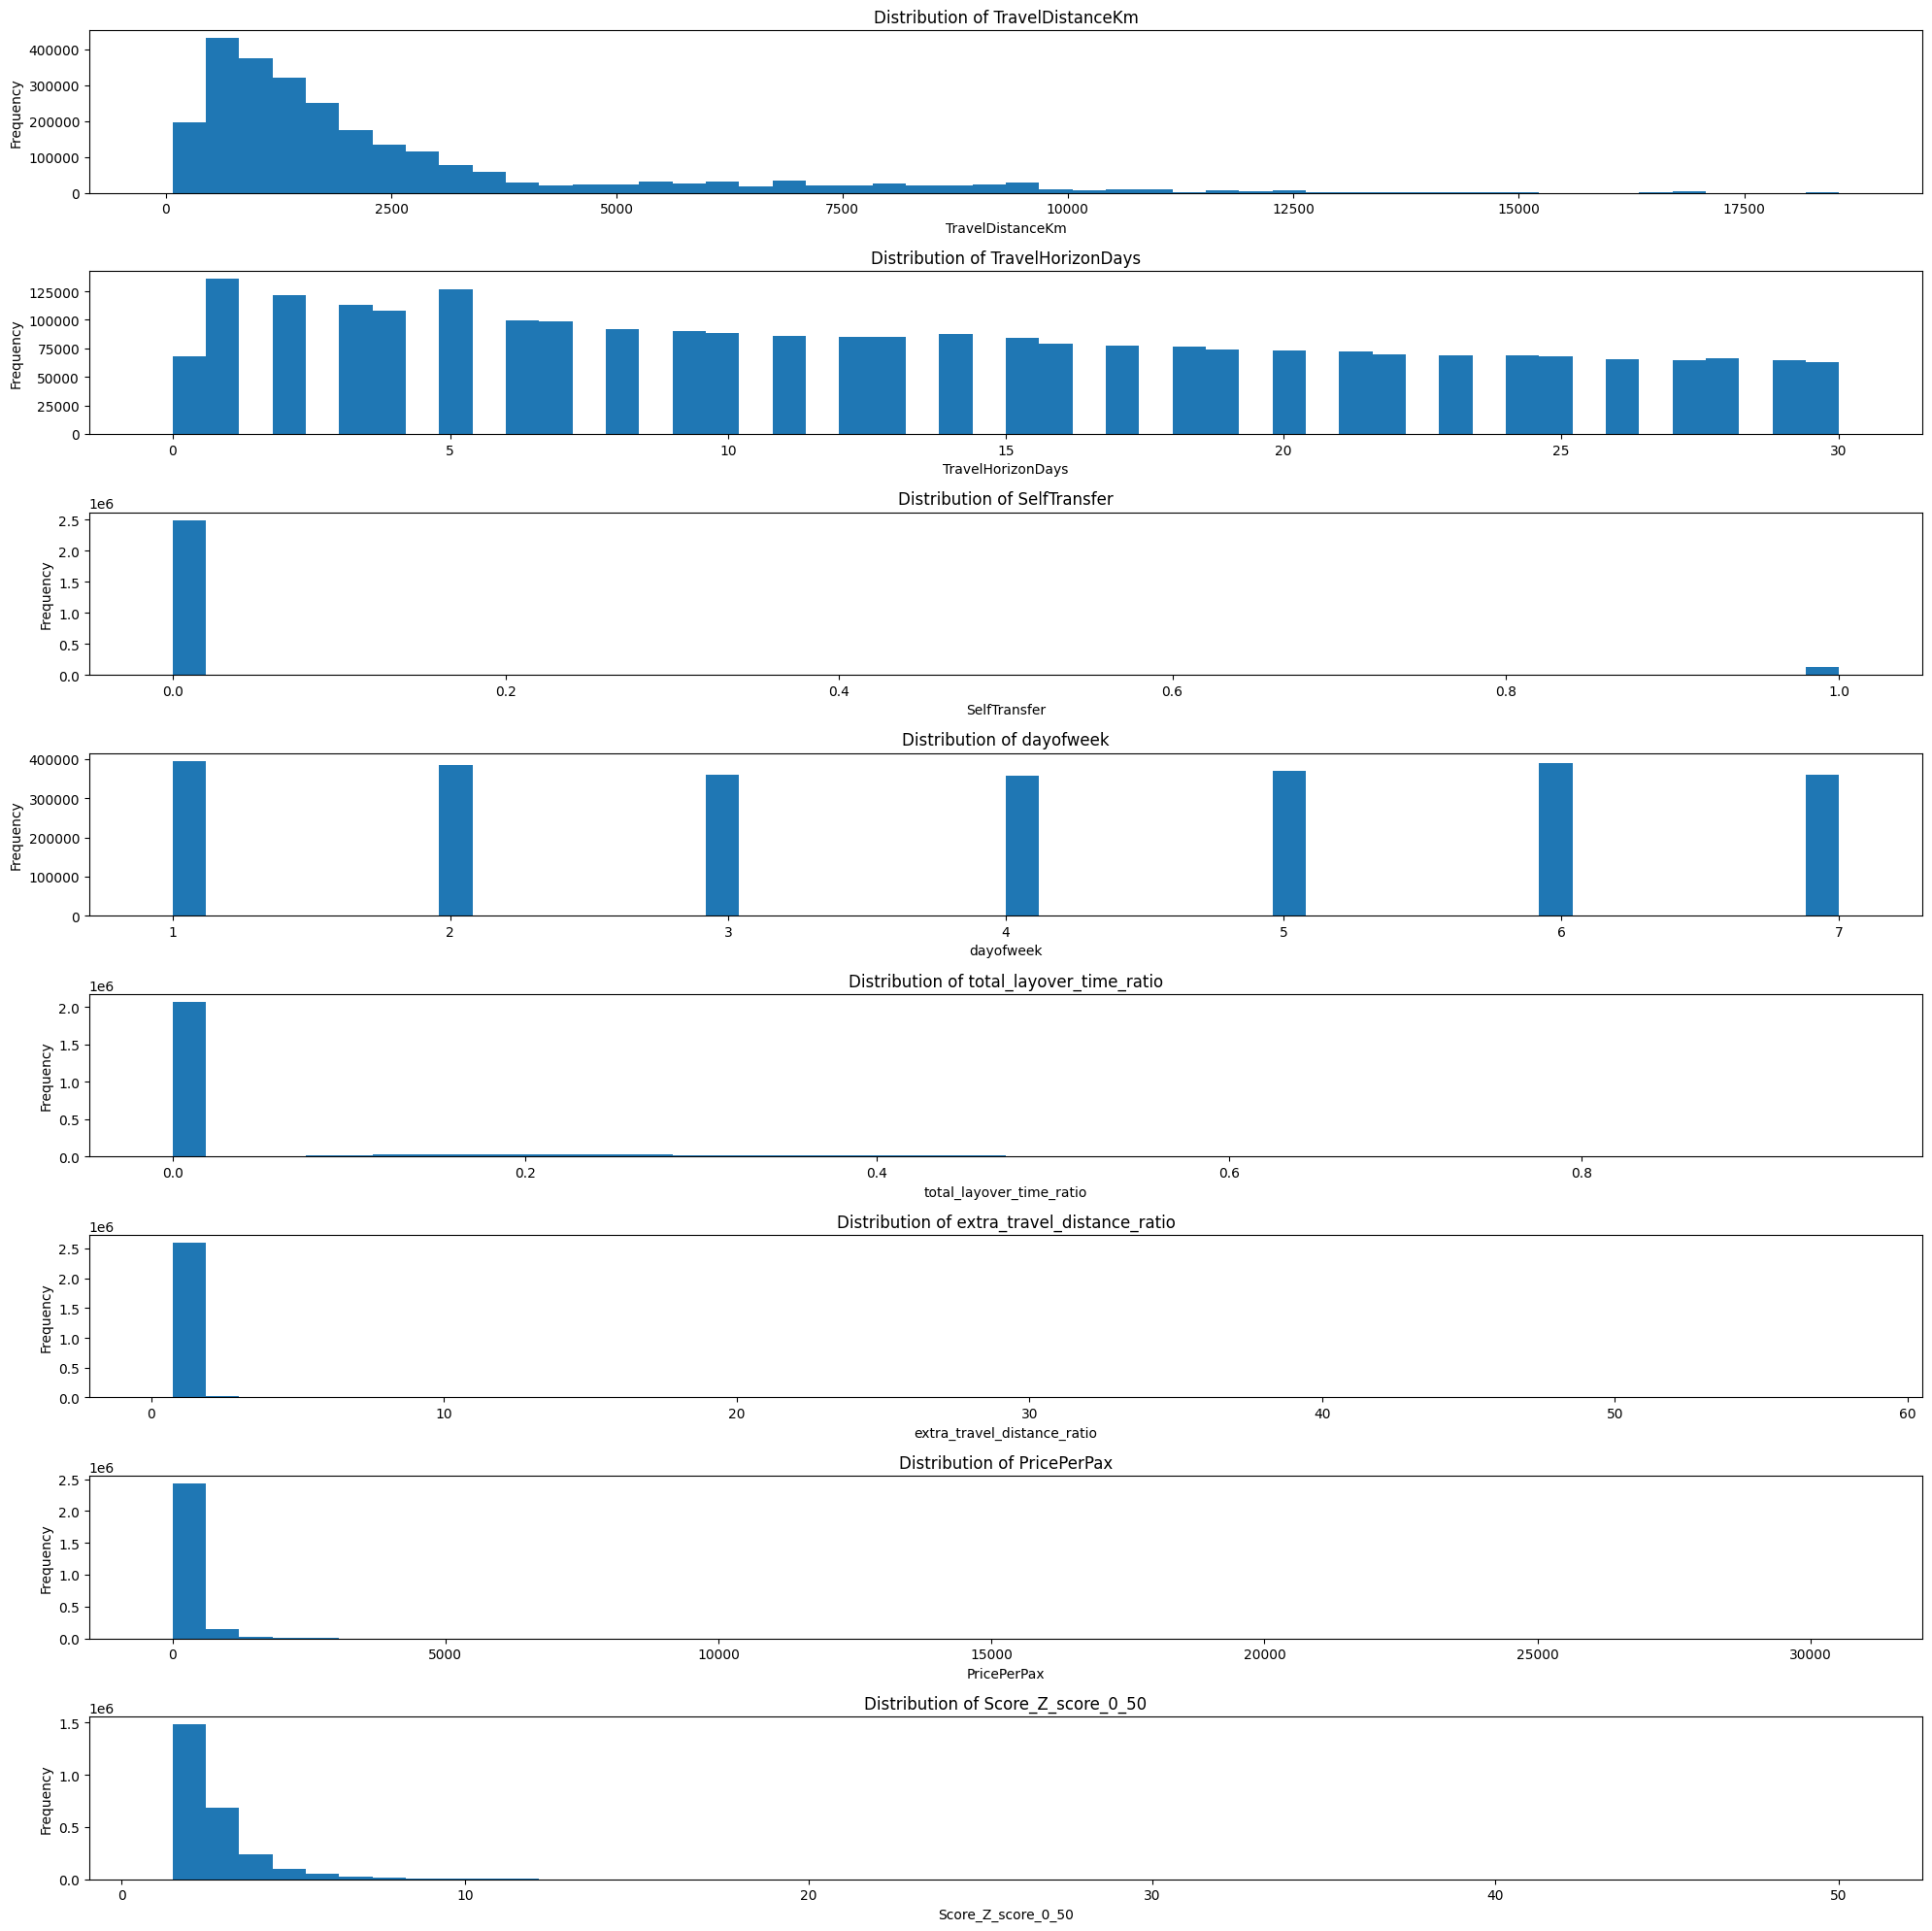

In [119]:
# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(model_data.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    model_data[heading].plot.hist(bins=50)
    plt.title(f'Distribution of {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Feature Engineering
- Log of extra_travel_distance
- Log of PricePerPax
- Log of total_layover_time_ratio
- Log of TravelDistanceKm

New target reqiures replacment of NaNs by zeros

In [120]:
# model_data.dropna(inplace=True)


In [121]:
# model_data.isna().any().any()


In [122]:
# model_data.isna().sum()


In [123]:
model_data.head()


,TravelDistanceKm,TravelHorizonDays,SelfTransfer,dayofweek,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,Score_Z_score_0_50
0,1859.0,2,0,2,0.000000,1.000000,108.870000,2.064894
1,1859.0,16,0,4,0.000000,1.000000,92.105556,9.175725
2,1859.0,26,1,2,0.843636,1.112426,63.710000,2.064894
3,1859.0,22,1,1,0.452055,1.013448,120.518333,3.842602
4,1859.0,6,0,6,0.000000,1.000000,167.967500,2.953748


In [124]:
# List of columns to transform
columns_to_transform = ['extra_travel_distance_ratio', 'PricePerPax', 'total_layover_time_ratio', 'TravelDistanceKm']

# Apply the transformation in a loop
for column in columns_to_transform:
    model_data.loc[:, column] = np.log1p(model_data[column])


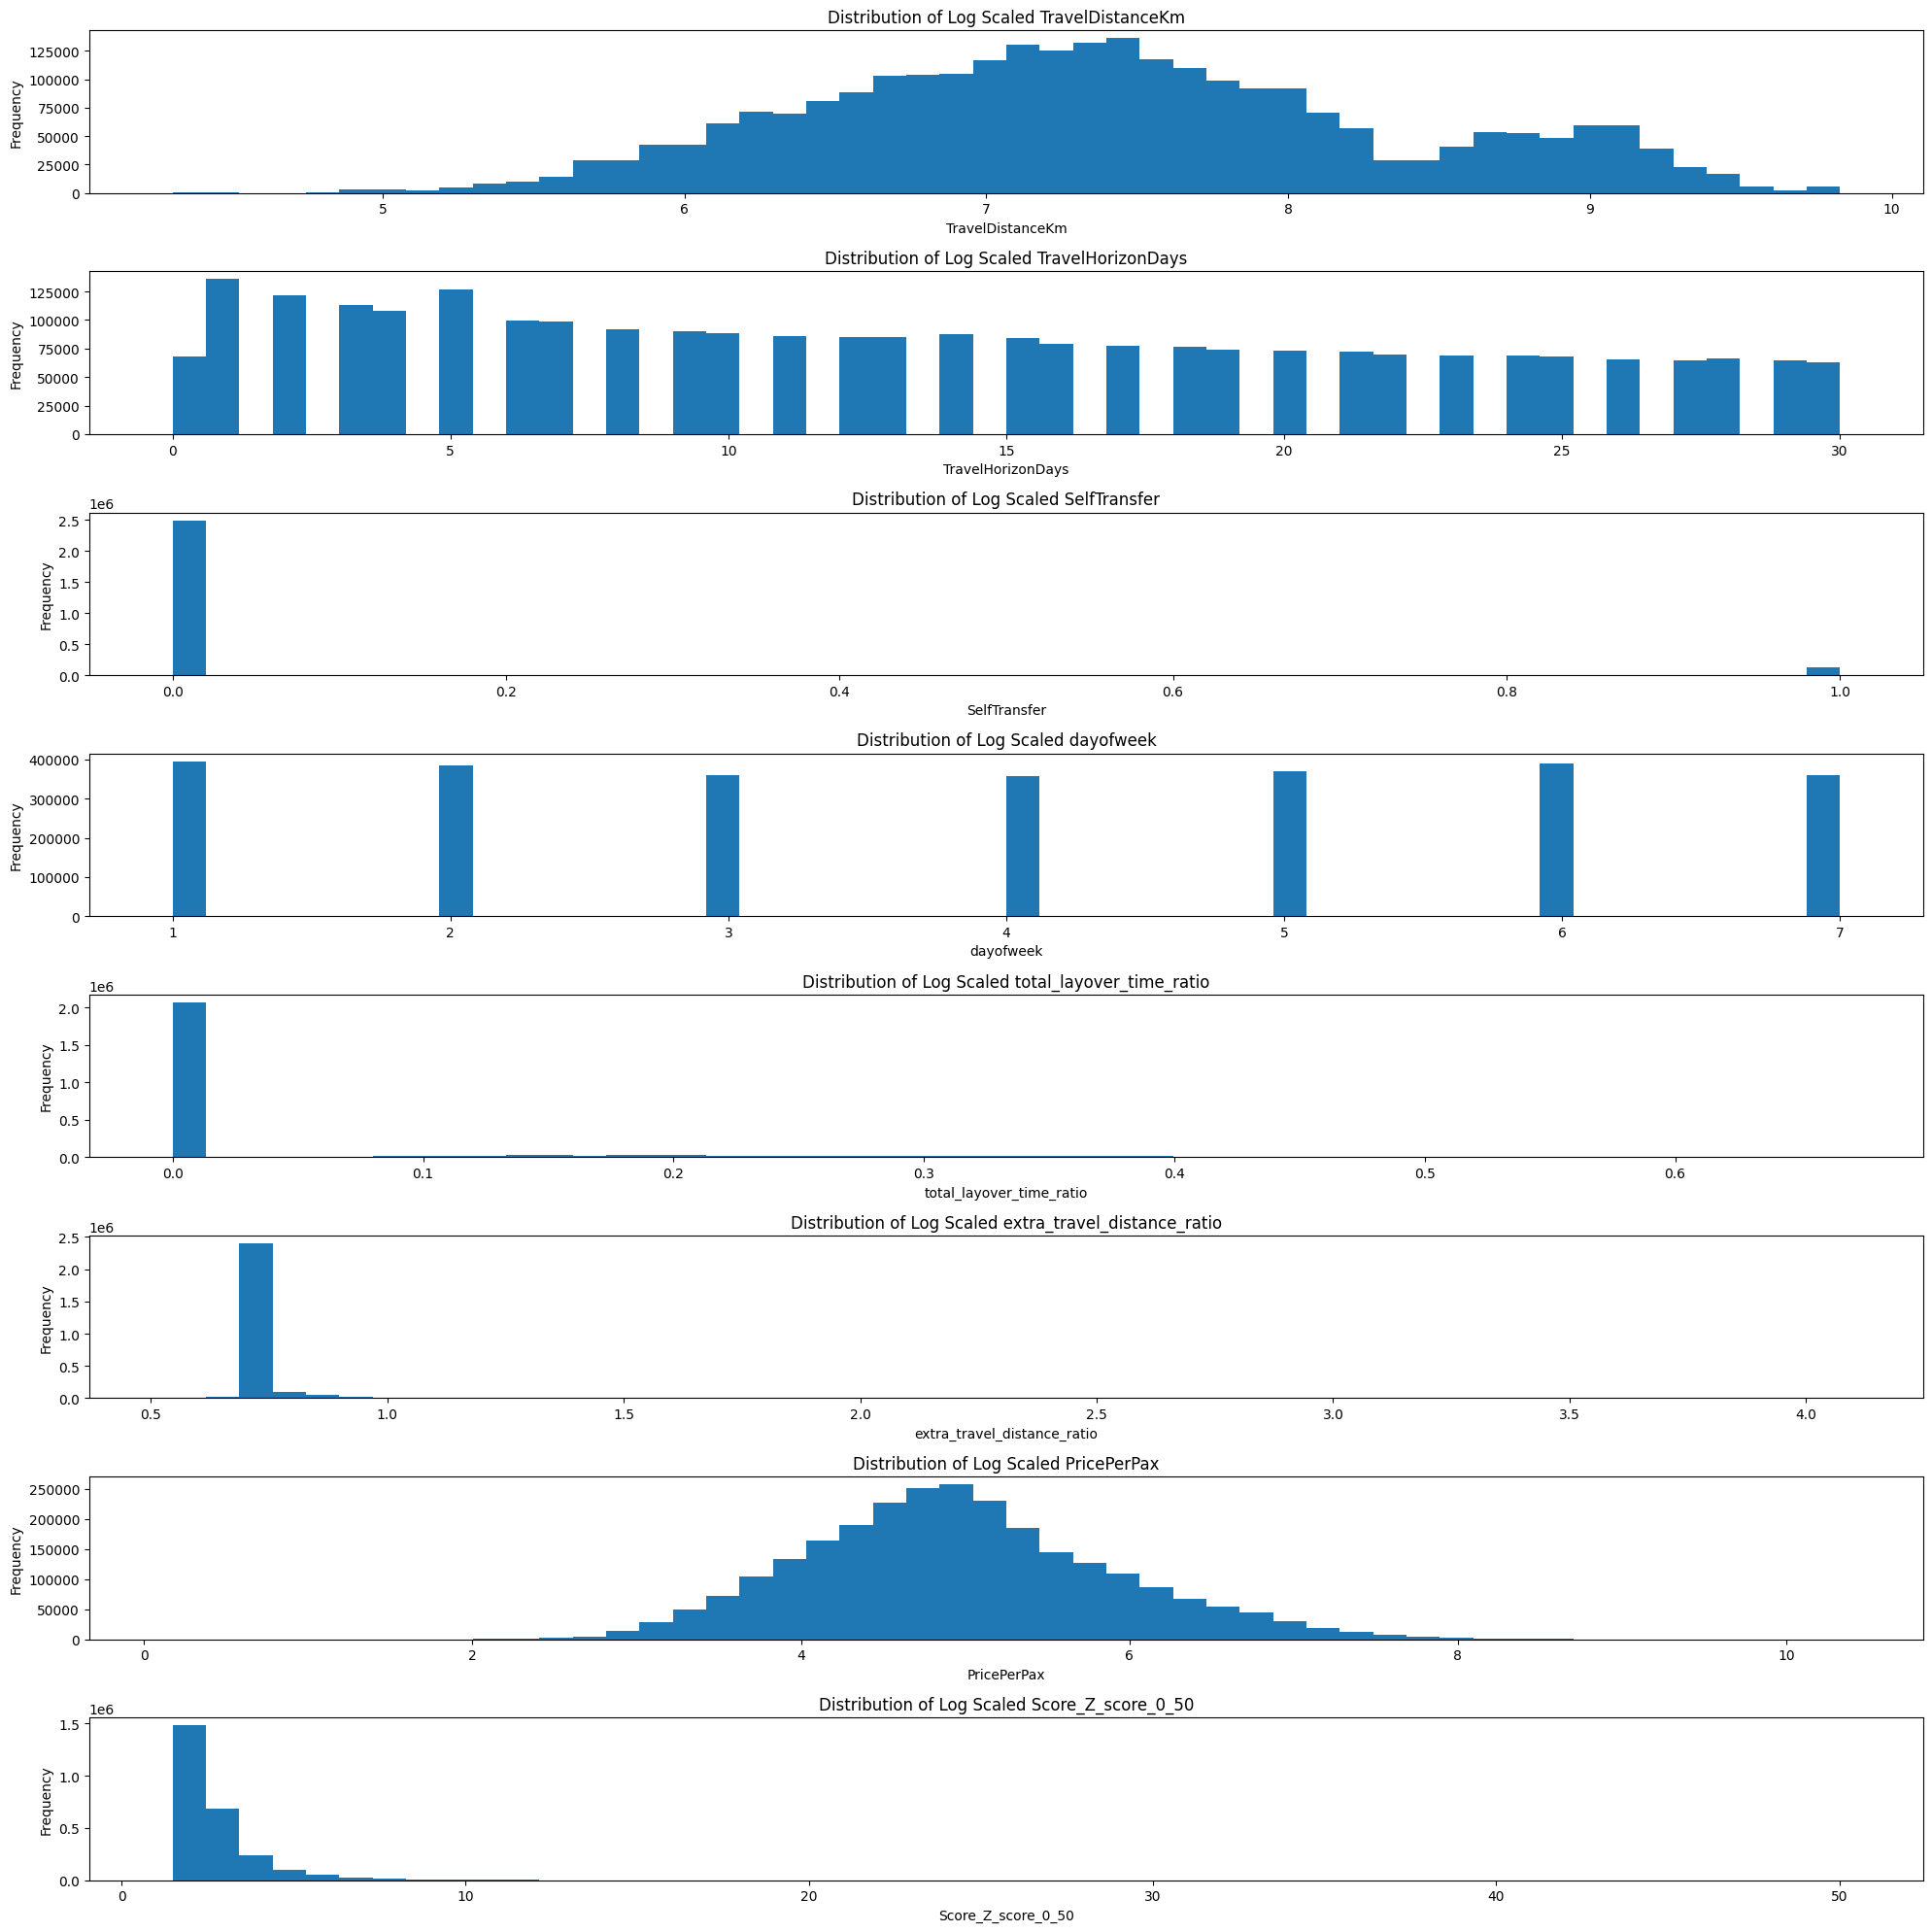

In [125]:
# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(model_data.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    model_data[heading].plot.hist(bins=50)
    plt.title(f'Distribution of Log Scaled {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Apply MinMax Scalar

In [126]:
scaler = MinMaxScaler()


In [127]:
X_train, X_test, y_train, y_test = create_train_test_split(model_data, 'Score_Z_score_0_50')


In [128]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [129]:
# model = Sequential()
# model.add(layers.Dense(64, input_dim=7, activation='relu'))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(1, activation='linear'))


In [130]:
# model.summary()


In [131]:
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=2, verbose=1, mode='min', restore_best_weights=True)


In [132]:
# model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [133]:
# model.fit(X_train, y_train, epochs=15, batch_size=128, verbose=1, callbacks=[early_stopping], validation_split=0.2)


In [134]:
#model.save('new_target_model11Dec23.h5')


In [135]:
model = load_model('../models/new_target_model11Dec23.h5')


In [136]:
# Evaluate the model on the test set
test_loss, test_error = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Error (MAE): {test_error}")


16382/16382 [==============================] - 25s 1ms/step - loss: 1.5640 - mae: 0.7921
Test Loss (MSE): 1.563984751701355
Test Error (MAE): 0.7920533418655396


In [137]:
y_pred = model.predict(X_test)


16382/16382 [==============================] - 28s 2ms/step


In [138]:
y_diff = y_pred.flatten() - y_test


In [139]:
y_diff_abs = y_diff.abs()


<Axes: ylabel='Count'>

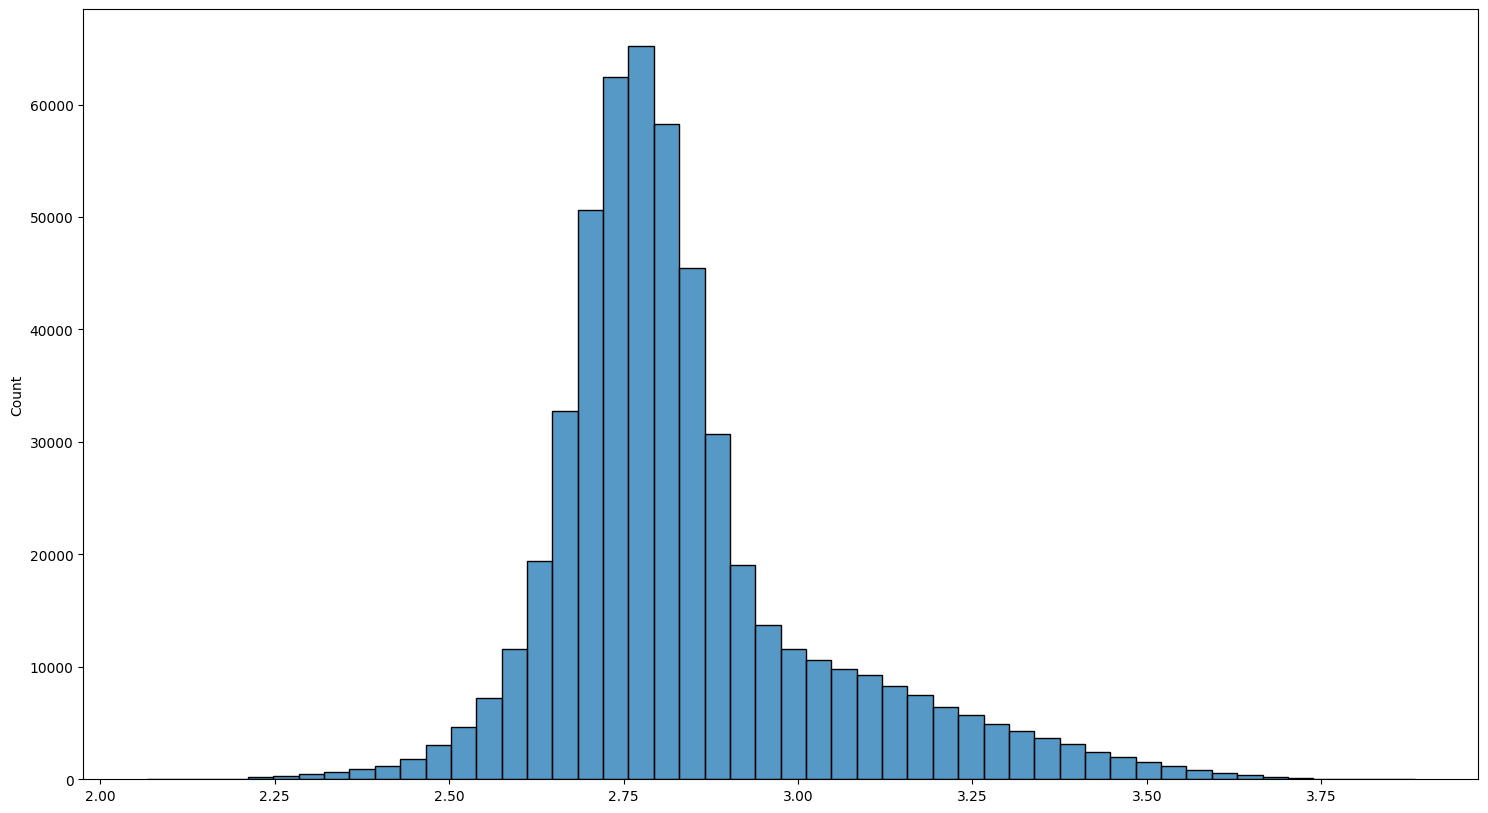

In [140]:
plt.figure(figsize = (18, 10))
sns.histplot(y_pred.flatten(), bins=50)


In [141]:
dohop_test = pd.read_csv("../raw_data/DohopTest11Dec.csv")
dohop_test.head()


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500


In [142]:
dohop_test.describe()


,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare
count,2.019379e+06,2.019379e+06,2.019379e+06,2.019379e+06,1222.000000,1222.000000,1222.000000,2.010518e+06,2.018040e+06,867298.000000
mean,3.526366e+02,6.585084e+02,1.555880e+01,4.061788e+00,1.392799,1.076923,216.435158,3.640327e+03,3.015621e+03,269.931992
std,1.827264e+02,3.877432e+02,9.029977e+00,2.122037e+00,0.818228,0.349059,134.723815,2.542659e+03,2.443641e+03,179.541142
min,3.500000e+01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,1.000000,32.108668,1.985210e+02,7.973600e+01,28.605000
25%,2.250000e+02,3.100000e+02,8.000000e+00,2.000000e+00,1.000000,1.000000,119.781404,1.882286e+03,1.198301e+03,156.872560
50%,3.050000e+02,6.000000e+02,1.600000e+01,4.000000e+00,1.000000,1.000000,179.984527,2.917531e+03,2.221155e+03,209.874400
75%,4.350000e+02,9.750000e+02,2.300000e+01,6.000000e+00,2.000000,1.000000,267.501876,4.597788e+03,4.138534e+03,326.525417
max,1.425000e+03,1.440000e+03,3.000000e+01,7.000000e+00,11.000000,7.000000,897.596446,1.844596e+04,1.733374e+04,7455.450000


In [143]:
dohop_test["SelfTransfer"] = 1
dohop_test.head()


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare,SelfTransfer
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500,1
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667,1
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333,1
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806,1
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500,1


In [144]:
dohop_test['total_layover_time_ratio'] = dohop_test["connection_time"] / (dohop_test["connection_time"] + dohop_test["total_flight_time"])
dohop_test.head()


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare,SelfTransfer,total_layover_time_ratio
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500,1,0.512195
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667,1,0.247059
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333,1,0.589744
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806,1,0.352941
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500,1,0.346535


In [145]:
dohop_test["extra_travel_distance_ratio"] = dohop_test["total_distance"] / dohop_test["direct_distance"]
dohop_test.head()


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500,1,0.512195,1.854818
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667,1,0.247059,1.016140
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333,1,0.589744,1.197750
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806,1,0.352941,1.106451
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500,1,0.346535,1.101503


In [146]:
dohop_test.rename(columns={"total_distance": "TravelDistanceKm", "days_to_travel": "TravelHorizonDays", "itinerary_fare": "PricePerPax", },inplace=True)
dohop_test.columns


Index(['flights', 'origin_iata', 'destination_iata', 'connection_airport',
       'total_flight_time', 'connection_time', 'TravelHorizonDays',
       'dayofweek', 'pax', 'bookings', 'booked_fare', 'TravelDistanceKm',
       'direct_distance', 'PricePerPax', 'SelfTransfer',
       'total_layover_time_ratio', 'extra_travel_distance_ratio'],
      dtype='object')

In [147]:
model_columns


['TravelDistanceKm',
 'TravelHorizonDays',
 'SelfTransfer',
 'dayofweek',
 'total_layover_time_ratio',
 'extra_travel_distance_ratio',
 'PricePerPax',
 'Score_Z_score_0_50']

In [148]:
dohop_columns = ['TravelDistanceKm',
 'TravelHorizonDays',
 'SelfTransfer',
 'dayofweek',
 'total_layover_time_ratio',
 'extra_travel_distance_ratio',
 'PricePerPax', "bookings"]


In [149]:
dohop_test = dohop_test[dohop_columns].copy()


In [150]:
dohop_test["bookings"].fillna(0, inplace=True)


In [151]:
dohop_test.isna().sum()


TravelDistanceKm                  8861
TravelHorizonDays                    0
SelfTransfer                         0
dayofweek                            0
total_layover_time_ratio             0
extra_travel_distance_ratio       8861
PricePerPax                    1152081
bookings                             0
dtype: int64

In [152]:
dohop_test.dropna(inplace=True)
dohop_test.isna().sum()


TravelDistanceKm               0
TravelHorizonDays              0
SelfTransfer                   0
dayofweek                      0
total_layover_time_ratio       0
extra_travel_distance_ratio    0
PricePerPax                    0
bookings                       0
dtype: int64

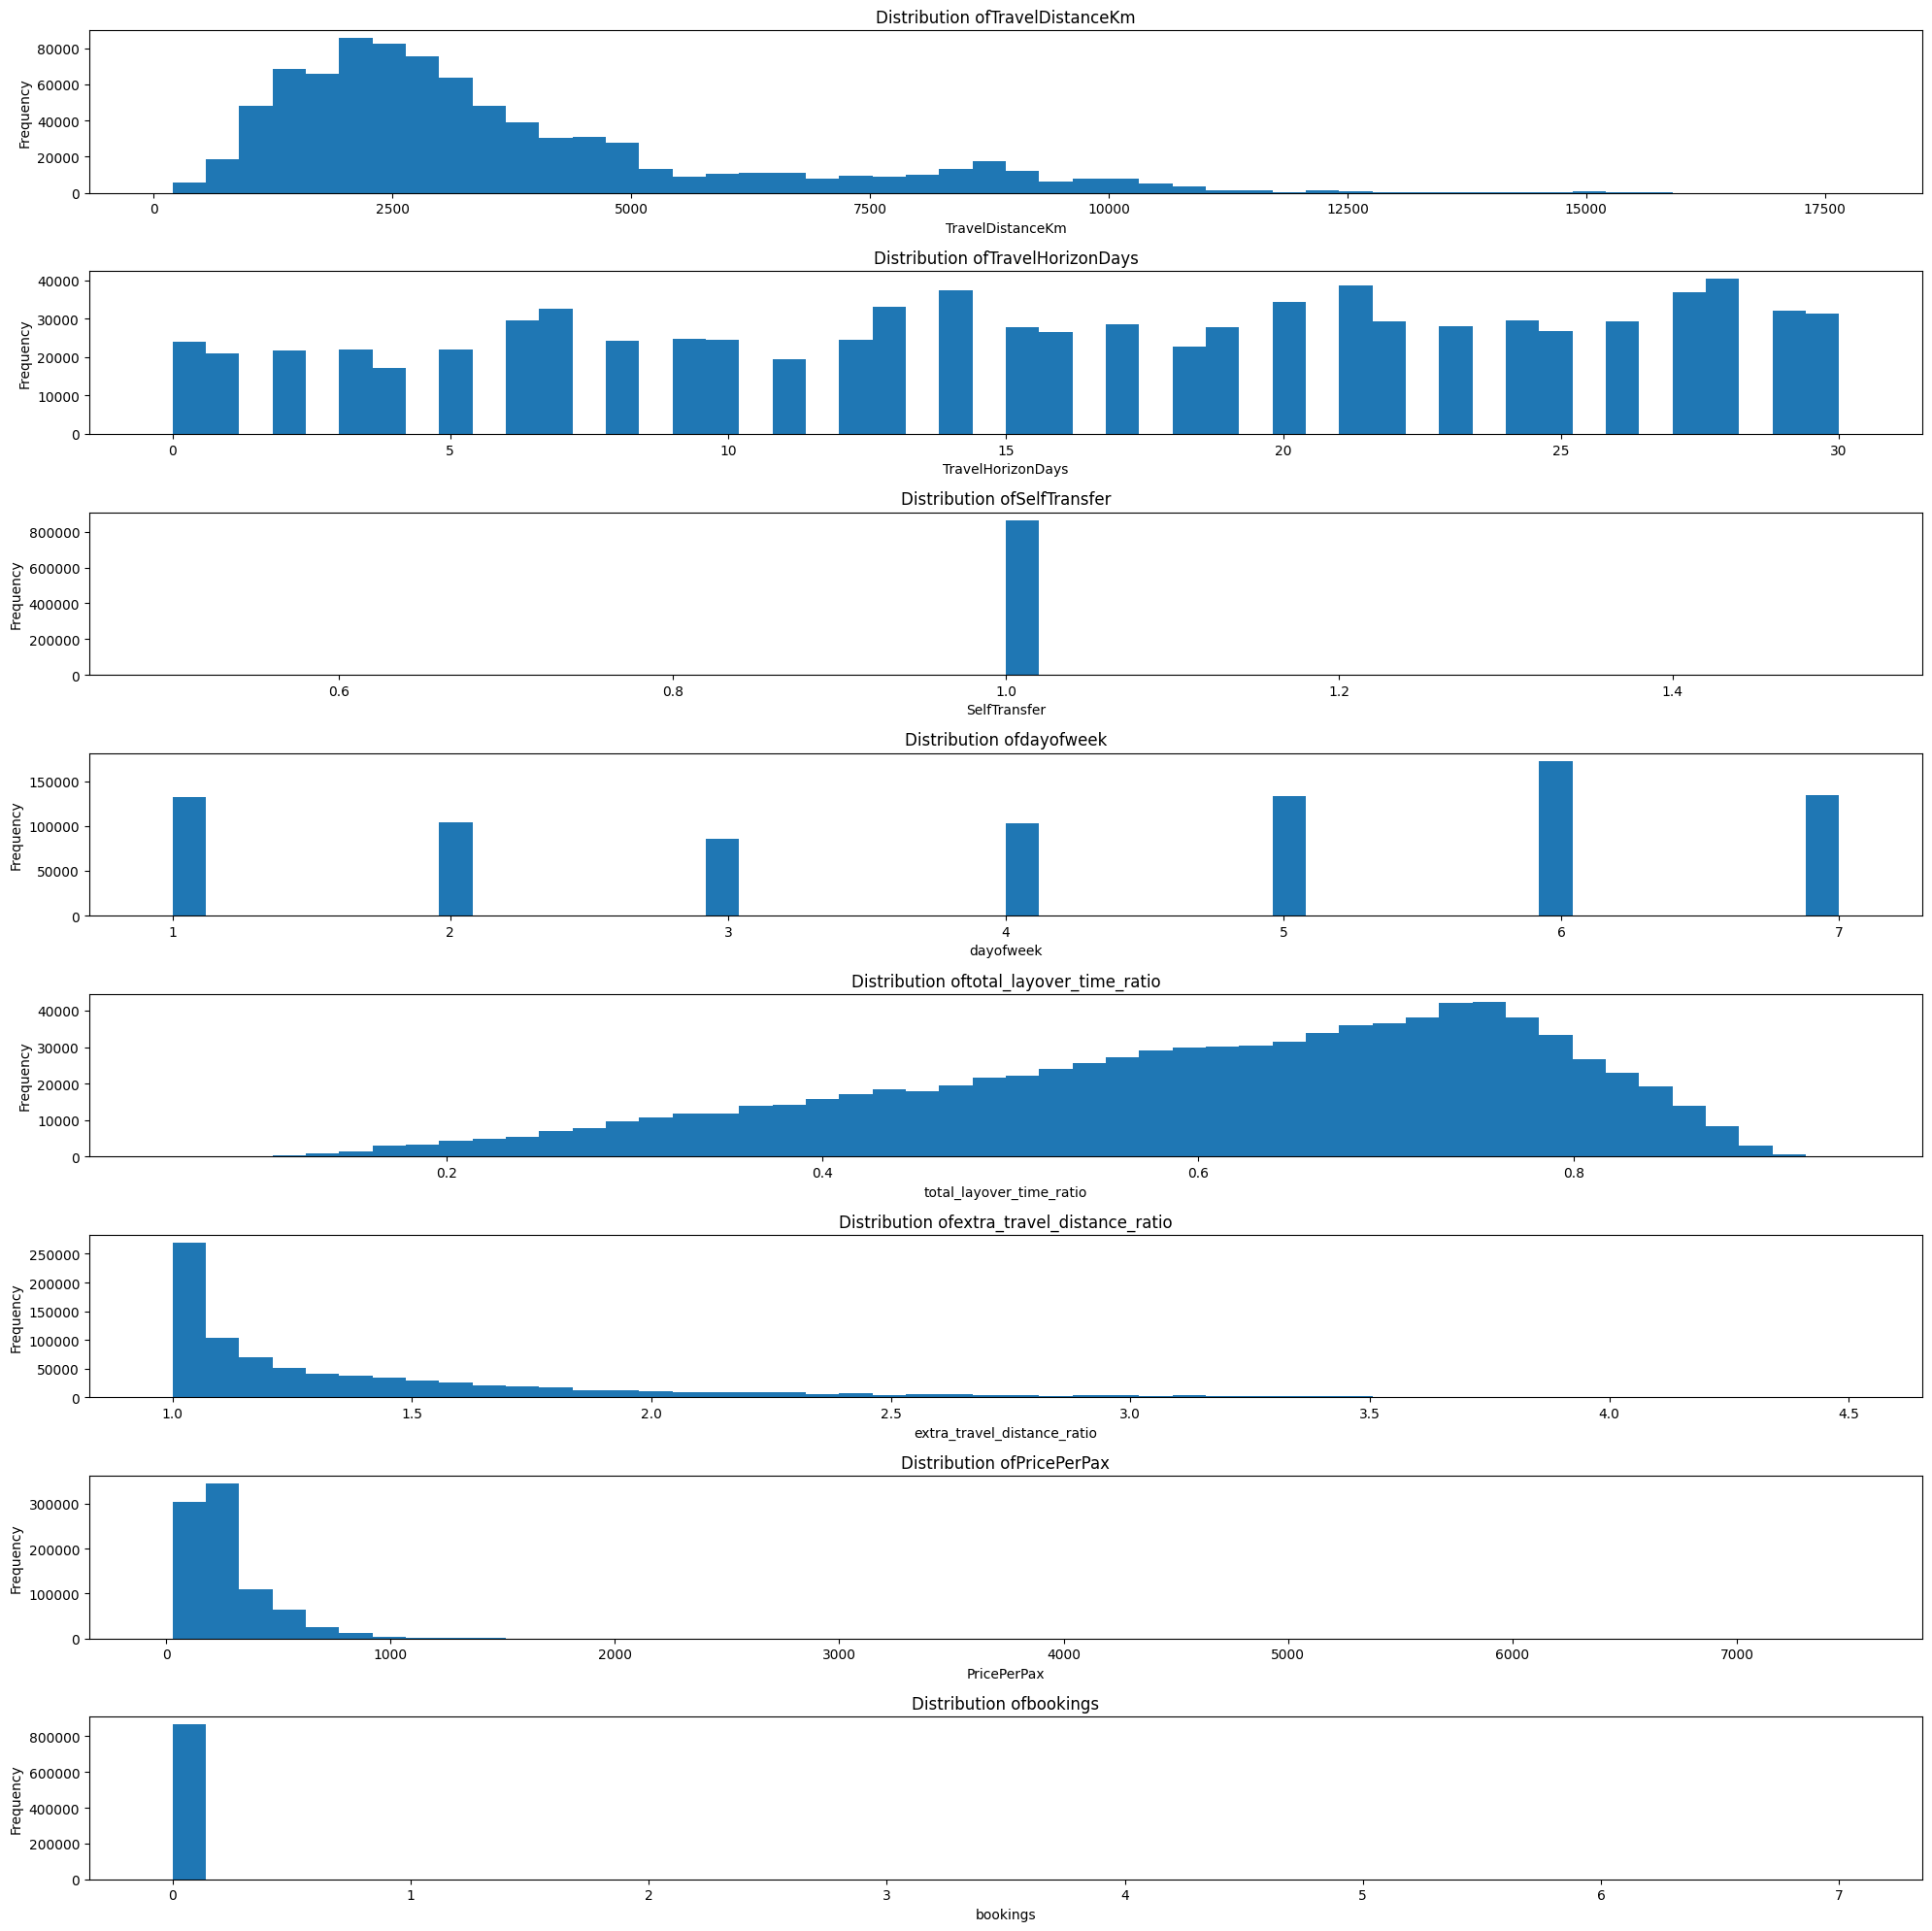

In [153]:
# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(dohop_test.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    dohop_test[heading].plot.hist(bins=50)
    plt.title(f'Distribution of{heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [154]:

# Apply the transformation in a loop
for column in columns_to_transform:
    dohop_test.loc[:, column] = np.log1p(dohop_test[column])


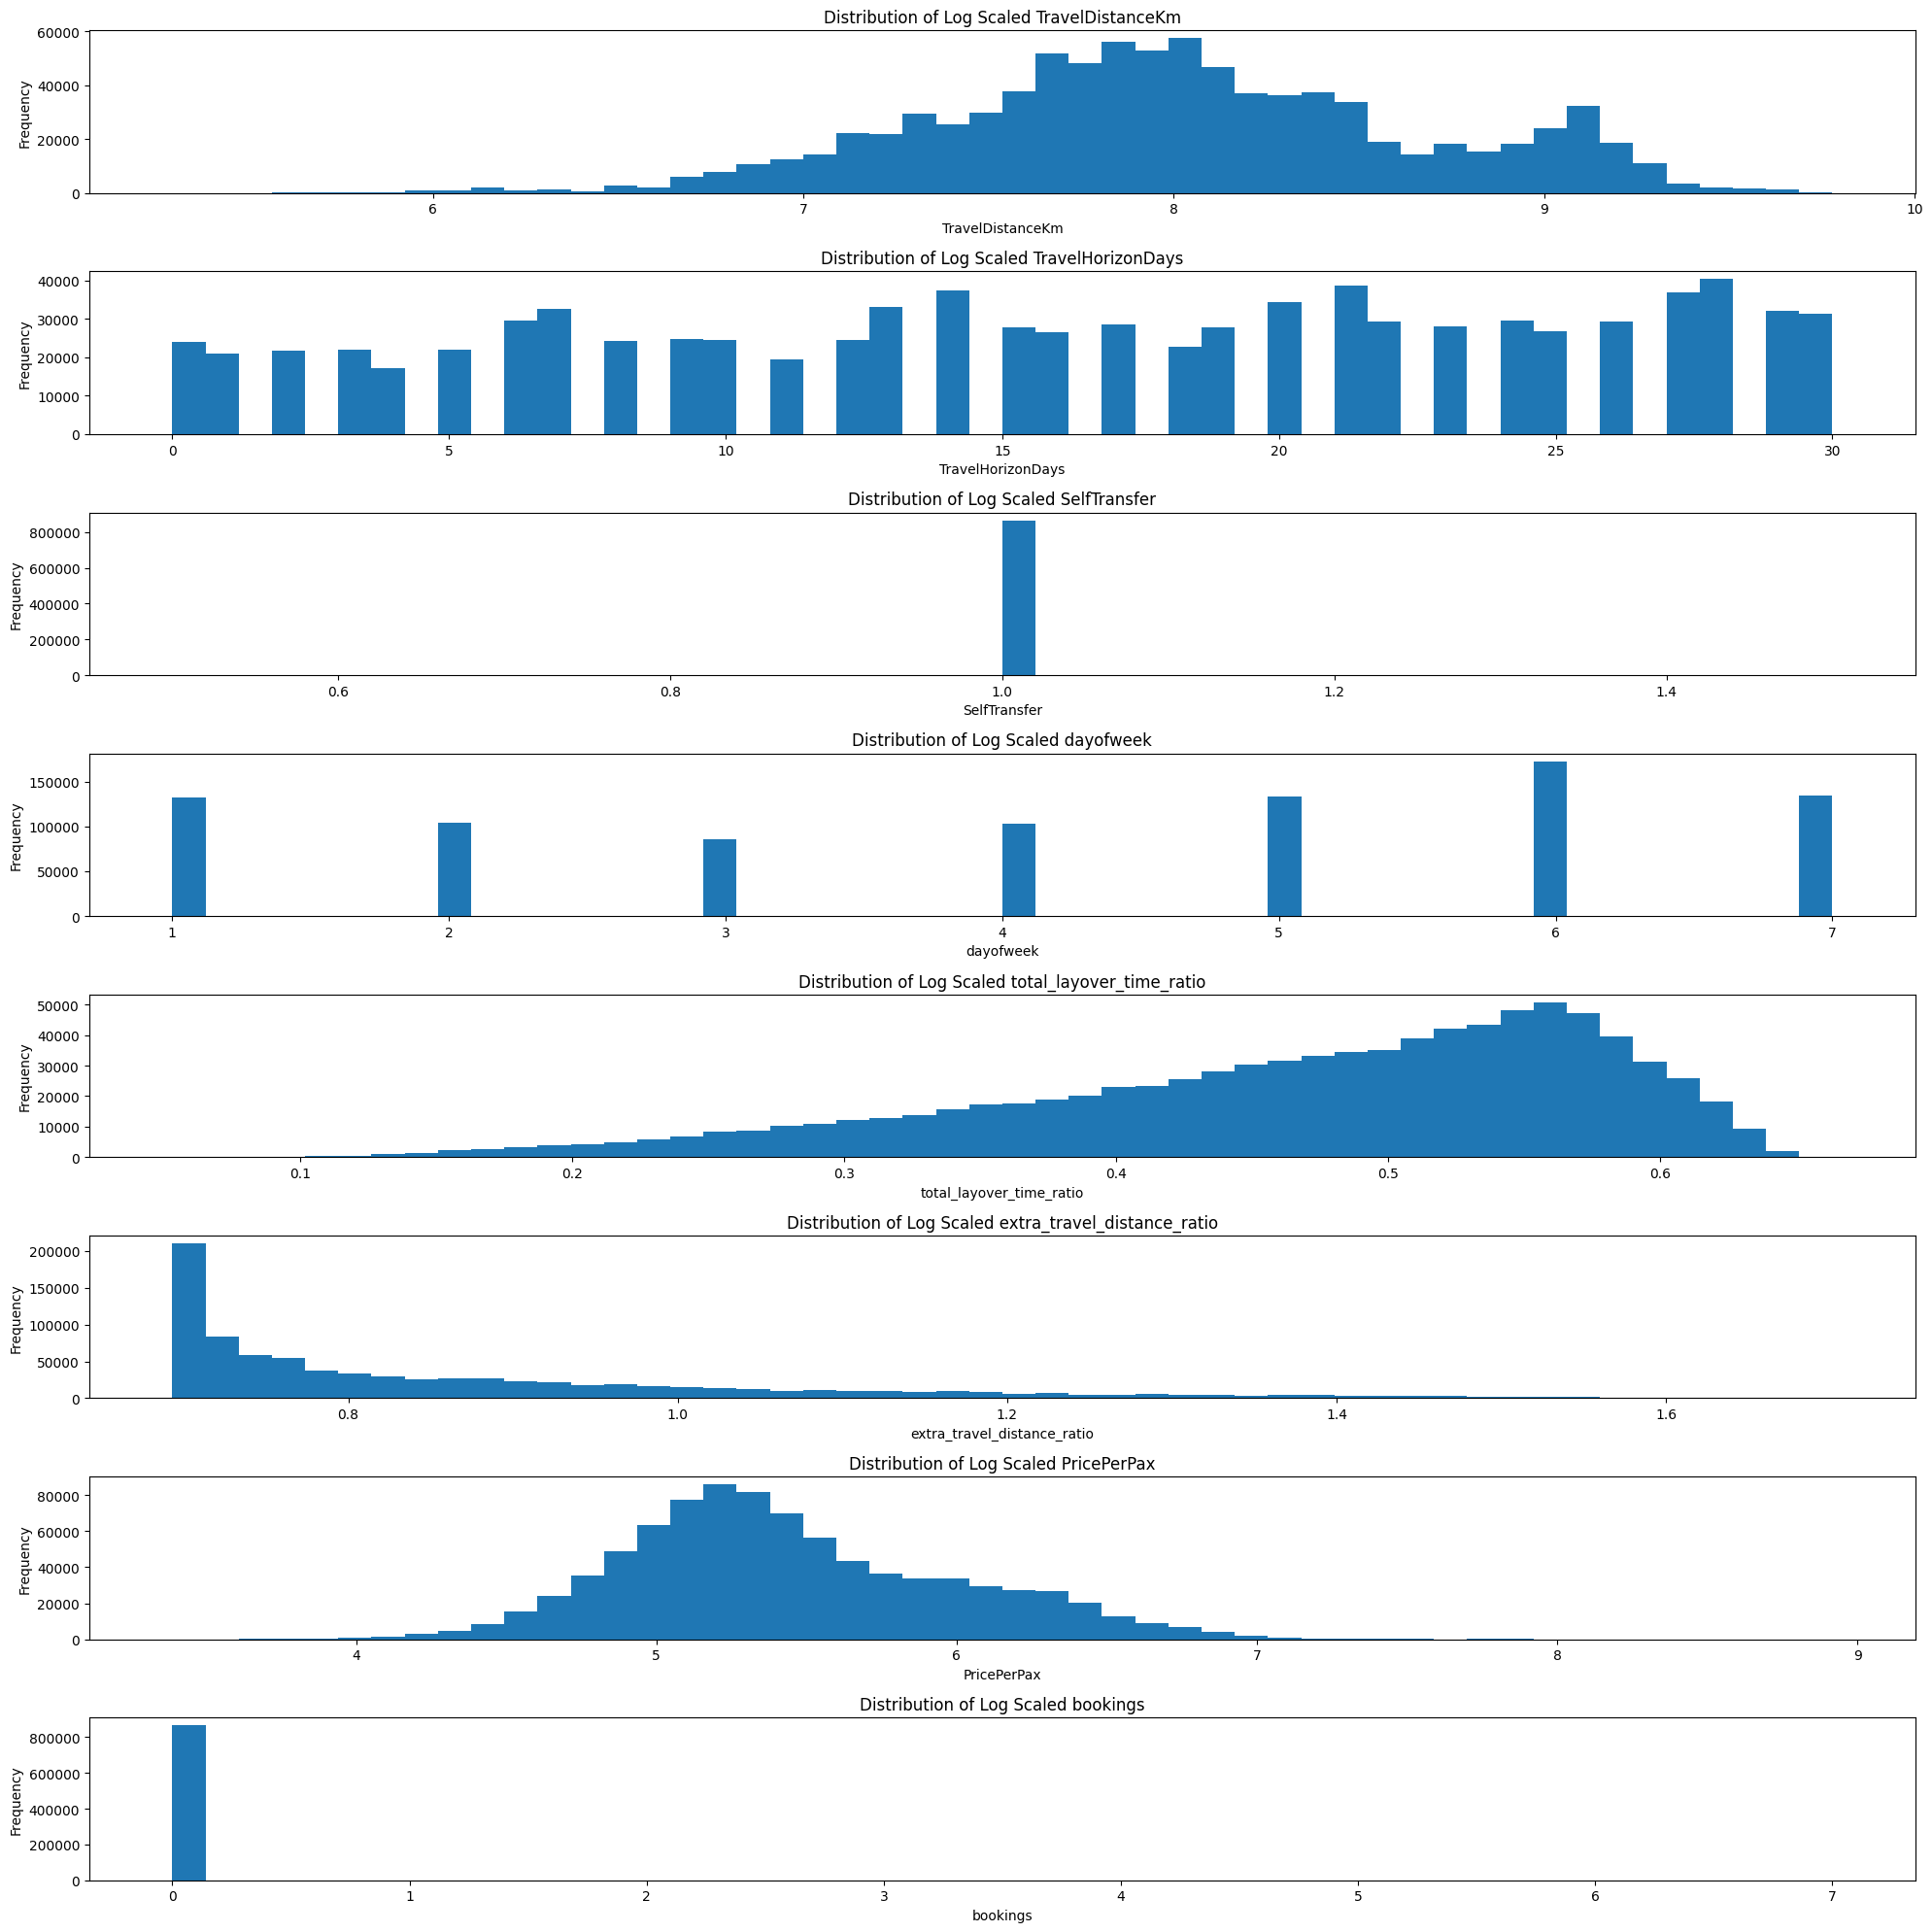

In [155]:
# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(dohop_test.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    dohop_test[heading].plot.hist(bins=50)
    plt.title(f'Distribution of Log Scaled {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [156]:
dohop_processing = dohop_test.copy()

In [157]:
bookings_column =   dohop_test["bookings"].copy()
dohop_test.drop(columns=["bookings"], inplace=True)


In [158]:
dohop_test_array = scaler.transform(dohop_test)


In [159]:
dohop_test = pd.DataFrame(dohop_test_array, columns=dohop_test.columns)


In [160]:
y_dohop_pred = model.predict(dohop_test)


27075/27075 [==============================] - 56s 2ms/step


In [161]:
dohop_test["bookings"] = bookings_column


In [162]:
dohop_test["Predicted_Score"] = y_dohop_pred.flatten()


In [163]:
sampled_data = dohop_test.sample(frac=0.001)
sampled_data.describe()


,TravelDistanceKm,TravelHorizonDays,SelfTransfer,dayofweek,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,bookings,Predicted_Score
count,866.000000,866.000000,866.0,866.000000,866.000000,866.000000,866.000000,386.0,866.000000
mean,0.674535,0.539492,1.0,0.540031,0.699901,0.090268,0.521337,0.0,2.523161
std,0.119921,0.291860,0.0,0.338877,0.160809,0.053858,0.053286,0.0,0.072851
min,0.308346,0.000000,1.0,0.000000,0.167637,0.041683,0.388202,0.0,2.349179
25%,0.604605,0.300000,1.0,0.166667,0.597300,0.047945,0.484956,0.0,2.468298
50%,0.666473,0.566667,1.0,0.666667,0.728808,0.070581,0.513817,0.0,2.517810
75%,0.748789,0.800000,1.0,0.833333,0.830835,0.116938,0.556357,0.0,2.570600
max,0.969572,1.000000,1.0,1.000000,0.965384,0.313585,0.699715,0.0,2.741249


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


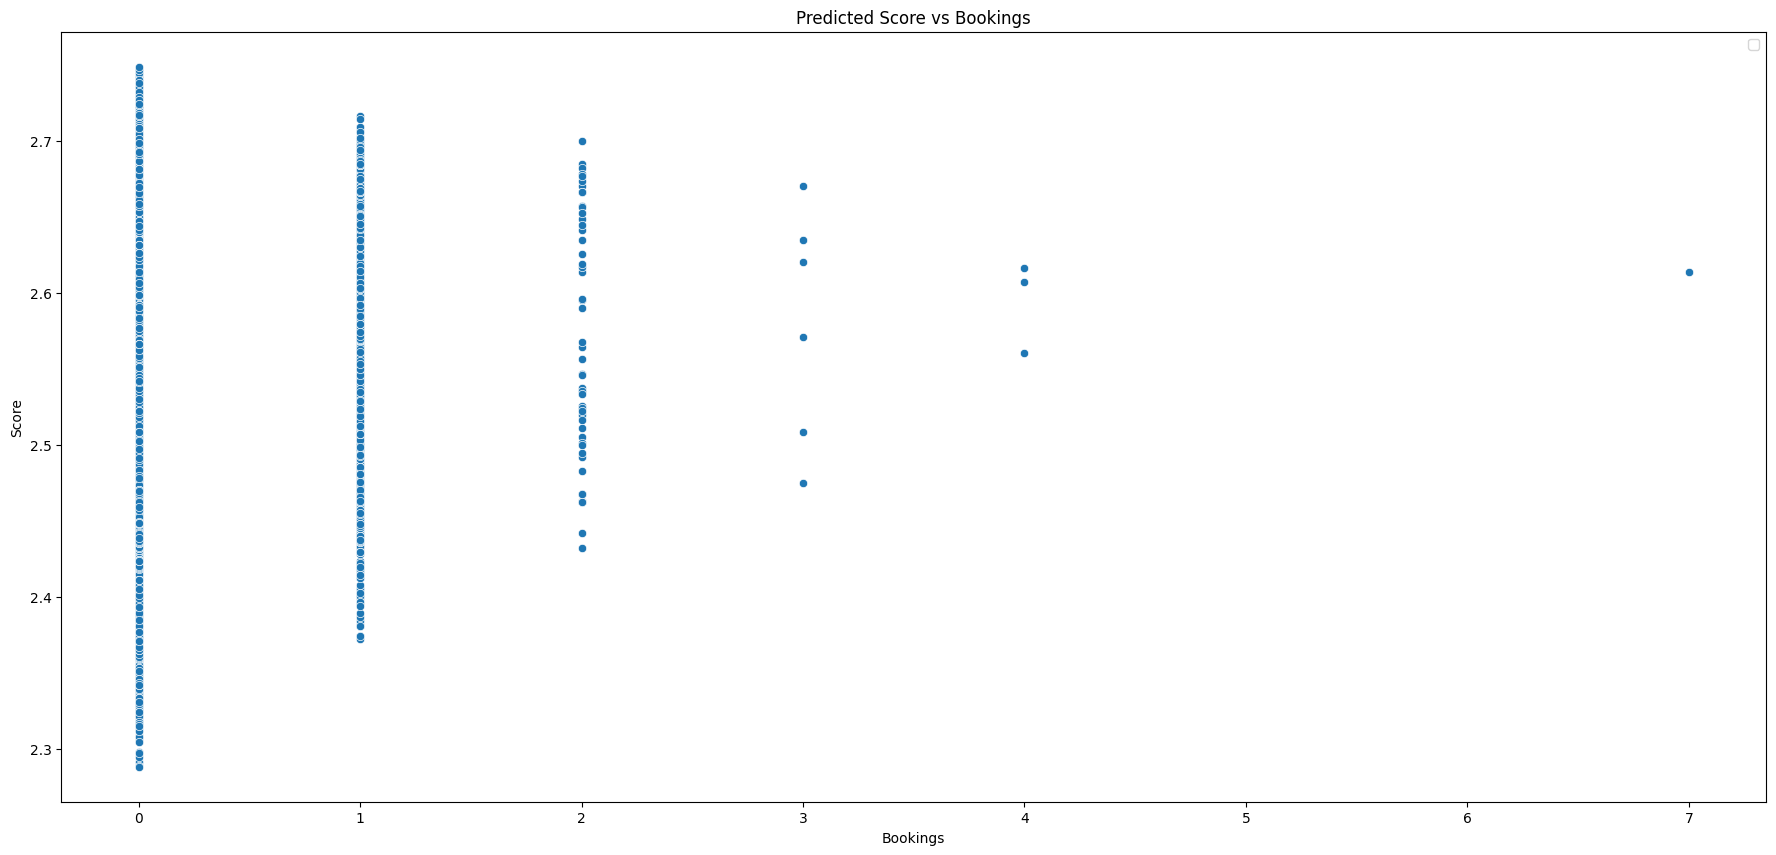

In [164]:
plt.figure(figsize = (22, 10))
sns.scatterplot(data=dohop_test, y=dohop_test["Predicted_Score"], x=dohop_test["bookings"])
plt.xlabel("Bookings")
plt.ylabel("Score")
plt.legend(loc='upper right')
plt.title("Predicted Score vs Bookings")
plt.show()


In [165]:
savings = dohop_test[dohop_test["Predicted_Score"] < 2.35]
savings.count() / dohop_test.count()


TravelDistanceKm               0.001091
TravelHorizonDays              0.001091
SelfTransfer                   0.001091
dayofweek                      0.001091
total_layover_time_ratio       0.001091
extra_travel_distance_ratio    0.001091
PricePerPax                    0.001091
bookings                       0.001052
Predicted_Score                0.001091
dtype: float64

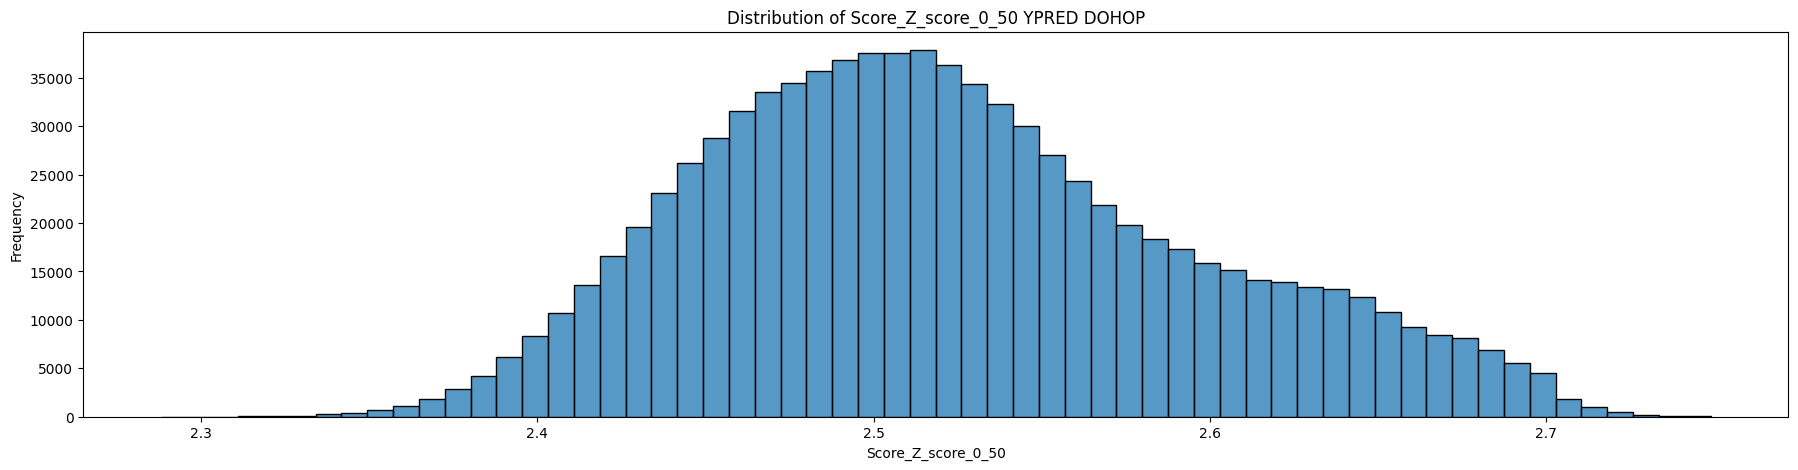

In [166]:
plt.figure(figsize = (22, 5))
sns.histplot(y_dohop_pred.flatten(), bins=60)
plt.xlabel("Score_Z_score_0_50")
plt.ylabel("Frequency")
plt.title("Distribution of Score_Z_score_0_50 YPRED DOHOP")
plt.show()


In [172]:
results = classification_evaluation(dohop_processing, model, scaler)

TypeError: classification_evaluation() takes 2 positional arguments but 3 were given